In [1]:
import pandas as pd
import sklearn as skl
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from imageio import mimwrite

from sklearn.preprocessing import (
    StandardScaler, QuantileTransformer)

import cartopy
import cartopy.crs as ccrs

from shapely.geometry import Polygon
from shapely.ops import cascaded_union

from datetime import date

import tensorflow as tf

from scipy.interpolate import (
    UnivariateSpline, LSQUnivariateSpline)

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
nytimes_data = pd.read_csv('~/nytimes/covid-19-data/us-counties.csv')

nytimes_data = nytimes_data.iloc[np.where(np.isfinite(nytimes_data[['fips']].values))[0]]

nytimes_data['predecessor_date'] = (
    [date.fromisoformat(x).toordinal() - 1 for x in nytimes_data['date']])

In [3]:
nytimes_data['state_id'] = 1000. * (nytimes_data[['fips']] // 1000)

In [4]:
## From US Census Bureau records
county_reader = cartopy.io.shapereader.Reader('./cb_2018_us_county_500k.shp')
counties = list(county_reader.records())
county_indices = pd.DataFrame({
    'GEOID' : [float(counties[i].attributes['GEOID']) for i in range(len(counties))],
    'index' : [i for i in range(len(counties))]})

In [5]:
with open('./co-est2019-alldata.csv', 'r') as fd:
    a = pd.read_csv('./co-est2019-alldata.csv', encoding='latin1')

all_pops = pd.DataFrame({
    'POP' : a[['POPESTIMATE2019']].values.reshape(-1),
    'fips' : a[['STATE']].values.reshape(-1) * 1000. + a['COUNTY'].values.reshape(-1)
})

state_pops = all_pops[a['COUNTY'].values.reshape(-1) == 0]
county_pops = all_pops[a['COUNTY'].values.reshape(-1) != 0]

In [6]:
extended_county_data = nytimes_data.merge(county_pops, left_on='fips', right_on='fips')

In [7]:
extended_state_data = nytimes_data.merge(state_pops, left_on='state_id', right_on='fips')

In [8]:
extended_county_data['normalized_cases'] = extended_county_data[['cases']].values.reshape(-1) / extended_county_data[['POP']].values.reshape(-1)
extended_county_data['normalized_deaths'] = extended_county_data[['deaths']].values.reshape(-1) / extended_county_data[['POP']].values.reshape(-1)

In [9]:
county_data = extended_county_data.groupby(['state', 'county', 'predecessor_date']).sum()

The state population data in each row gets confused by the fact that we add the state id many times for each data. We have to do this is two steps -- first take the sum for each column, and then replace the state_id and population for each row with the single alue it should have. This cheat is ugly, but it works.

In [10]:
mean_state_data = extended_state_data.groupby(['state', 'predecessor_date']).mean()

In [11]:
state_data = extended_state_data.groupby(['state', 'predecessor_date']).sum()

In [12]:
state_data['state_id'] = mean_state_data['state_id']
state_data['POP'] = mean_state_data['POP']

In [13]:
state_data['normalized_cases'] = state_data[['cases']].values.reshape(-1) / state_data[['POP']].values.reshape(-1)
state_data['normalized_deaths'] = state_data[['deaths']].values.reshape(-1) / state_data[['POP']].values.reshape(-1)

In [14]:
def build_county_stats_dict():
    county_stats_dict = {}
    for state_name in np.unique(county_data.index.get_level_values(0)):
        restricted_county_data = county_data[county_data.index.get_level_values(0) == state_name]
    
        for county_name in np.unique(restricted_county_data.index.get_level_values(1)):
            county_cases = restricted_county_data[restricted_county_data.index.get_level_values(1) == county_name]
        
            if county_cases.shape[0] < 20:
                continue
            
            x = county_cases.index.get_level_values(2).values.reshape(-1)[1:]
            y_base = county_cases[['normalized_deaths']].cummax().values.reshape(-1)
            y = y_base[1:] - y_base[:-1]
            y_max = np.max(y)
            y = y / y_max
            
            spl = UnivariateSpline(x, y)
            ##spl.set_smoothing_factor(10)
                
            xs = np.arange(np.min(x) + 1, np.max(x) + 1)
            ys = spl(xs)
            dydxs = spl.derivative(1)(xs)
            
            base_fips = np.empty([x.shape[0]])
            base_fips[:] = county_cases[['fips']].values.reshape(-1)[0]
            smoothed_fips = np.empty([xs.shape[0]])
            smoothed_fips[:] = county_cases[['fips']].values.reshape(-1)[0]
                
            county_stats_dict[int(county_cases[['fips']].values.reshape(-1)[0])] = (            
                {
                    'base_diffs' : np.vstack((base_fips, x, y)).T, 
                    'smoothed_diffs' : np.vstack((smoothed_fips, xs, ys)).T, 
                    'smoothed_diff_derivs': np.vstack((smoothed_fips, xs, dydxs)).T,
                })
            
    return county_stats_dict

county_stats_dict = build_county_stats_dict()

/Users/johnmerrill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [15]:
base_diffs_array = pd.DataFrame(
    np.vstack([county_stats_dict[fips]['base_diffs'] 
               for fips in list(county_stats_dict.keys())]))
base_diffs_array.columns = ['fips', 'x', 'y']

smoothed_diffs_array = pd.DataFrame(
    np.vstack([county_stats_dict[fips]['smoothed_diffs'] 
               for fips in list(county_stats_dict.keys())]))
smoothed_diffs_array.columns = ['fips', 'xs', 'ys']

smoothed_diff_derivs_array = pd.DataFrame(
    np.vstack([county_stats_dict[fips]['smoothed_diff_derivs'] 
               for fips in list(county_stats_dict.keys())]))
smoothed_diff_derivs_array.columns = ['fips', 'xs', 'dysdxs']

In [16]:
plot_normalizer = None

In [17]:
class plot_normalizer:
    def __init__(self, base_data):
        deriv_values = base_data.values[:, 2]
        valid_data = (
            deriv_values[np.isfinite(deriv_values)])
        
        self.positive_normalizer = (
            QuantileTransformer(n_quantiles=100))
        self.negative_normalizer = (
            QuantileTransformer(n_quantiles=100))
        
        self.positive_normalizer.fit(
            valid_data[valid_data > 0].reshape(-1, 1))
        self.negative_normalizer.fit(
            valid_data[valid_data < 0].reshape(-1, 1))
        
    def transform(self, base_data):
        data = base_data.reshape(-1, 1)
        positive_base = (
            self.positive_normalizer.transform(data))
        negative_base = (
            self.negative_normalizer.transform(data))
        
        positive = (positive_base + 1) / 2
        negative = negative_base / 2
        
        retval = np.empty(data.shape)
        retval[:] = 0.5
        retval[data > 0] = positive[data > 0]
        retval[data < 0] = negative[data < 0]
        
        return retval

In [18]:
base_diffs_normalizer = QuantileTransformer(n_quantiles=100)
base_diffs_normalizer.fit(
    base_diffs_array['y'].values[
        np.isfinite(base_diffs_array['y'].values)].reshape(-1, 1))

smoothed_diffs_normalizer = QuantileTransformer(n_quantiles=100)
smoothed_diffs_normalizer.fit(
    smoothed_diffs_array['ys'].values[
        np.isfinite(smoothed_diffs_array['ys'].values)].reshape(-1, 1))

#smoothed_diff_derivs_normalizer = (
#    plot_normalizer(smoothed_diff_derivs_array))
smoothed_diff_derivs_normalizer = QuantileTransformer(n_quantiles=100)
smoothed_diff_derivs_normalizer.fit(
    smoothed_diff_derivs_array['dysdxs'].values[
        np.isfinite(smoothed_diff_derivs_array['dysdxs'].values)].reshape(-1, 1))

QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=100,
                    output_distribution='uniform', random_state=None,
                    subsample=100000)

In [19]:
def plot_rate_change_county_cases(result_array, date):
    working_cmap = plt.get_cmap('coolwarm')
    
    restricted_result_array_precursor = (
        result_array[result_array['xs'].values.reshape(-1) == date]).merge(
        county_indices, left_on='fips', right_on='GEOID')
    
    good_rows = (
        np.setdiff1d(
            np.arange(restricted_result_array_precursor.shape[0]),
            np.where(~np.isfinite(restricted_result_array_precursor))[0]))
    
    restricted_result_array = (
        restricted_result_array_precursor.values[good_rows, :])
        
    central_lat = 37.5
    central_lon = -96
    extent = [-120, -70, 23, 50.5]
    central_lon = np.mean(extent[:2])
    central_lat = np.mean(extent[2:])

    fig, ax = plt.subplots(figsize=(24, 12))
    ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))
    ax.set_extent(extent)

    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.LAND, edgecolor='black')
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
    ax.add_feature(cartopy.feature.BORDERS)
        
    transformed_scores = (
        smoothed_diff_derivs_normalizer.transform(
            restricted_result_array[:, 2].reshape(-1, 1)))
    
    colors = [
        working_cmap(transformed_scores[i, 0])
        for i in range(restricted_result_array.shape[0])]
    
    ax.add_feature(
        cartopy.feature.ShapelyFeature(
            [counties[int(restricted_result_array[int(i), -1])].geometry 
             for i in range(restricted_result_array.shape[0])], 
            cartopy.crs.PlateCarree(),
            facecolor=colors))    
    ax.add_feature(cartopy.feature.STATES, edgecolor='lightgrey')

    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    plt.close()
    
    return image

In [20]:
rate_change_county_cases = [
    plot_rate_change_county_cases(smoothed_diff_derivs_array, image_date) 
    for image_date in np.unique(smoothed_diff_derivs_array['xs'].values)
]

In [21]:
mimwrite('./rate_change_county_cases.gif', 
         rate_change_county_cases,
         fps=2,
         subrectangles=True,
         loop=1)

In [22]:
def plot_county_rate_cases(result_array, date):
    working_cmap = plt.get_cmap('OrRd')
    
    restricted_result_array_precursor = (
        result_array[result_array['xs'].values.reshape(-1) == date]).merge(
        county_indices, left_on='fips', right_on='GEOID')
    
    good_rows = (
        np.setdiff1d(
            np.arange(restricted_result_array_precursor.shape[0]),
            np.where(~np.isfinite(restricted_result_array_precursor))[0]))
    
    restricted_result_array = (
        restricted_result_array_precursor.values[good_rows, :])
        
    central_lat = 37.5
    central_lon = -96
    extent = [-120, -70, 23, 50.5]
    central_lon = np.mean(extent[:2])
    central_lat = np.mean(extent[2:])

    fig, ax = plt.subplots(figsize=(24, 12))
    ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))
    ax.set_extent(extent)

    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.LAND, edgecolor='black')
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
    ax.add_feature(cartopy.feature.BORDERS)
        
    transformed_scores = (
        smoothed_diffs_normalizer.transform(
            restricted_result_array[:, 2].reshape(-1, 1)))
    
    colors = [
        working_cmap(transformed_scores[i, 0])
        for i in range(restricted_result_array.shape[0])]
    
    ax.add_feature(
        cartopy.feature.ShapelyFeature(
            [counties[int(restricted_result_array[int(i), -1])].geometry 
             for i in range(restricted_result_array.shape[0])], 
            cartopy.crs.PlateCarree(),
            facecolor=colors))    
    ax.add_feature(cartopy.feature.STATES, edgecolor='lightgrey')

    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    plt.close()
    
    return image

In [23]:
rate_county_cases = [
    plot_county_rate_cases(smoothed_diffs_array, image_date) 
    for image_date in np.unique(smoothed_diff_derivs_array['xs'].values)
]

In [24]:
mimwrite('./rate_county_cases.gif', 
         rate_county_cases,
         fps=2,
         subrectangles=True,
         loop=1)

In [60]:
def build_state_stats_dict(target_feature_name):
    state_stats_dict = {}
    for state_name in np.unique(state_data.index.get_level_values(0)):
        restricted_state_data = state_data[state_data.index.get_level_values(0) == state_name]
        state_cases = restricted_state_data[restricted_state_data[[target_feature_name]].values >= 20]
        
        if state_cases.shape[0] < 10:
            continue
    
        x = state_cases.index.get_level_values(1).values.reshape(-1)
        y_base = state_cases[[target_feature_name]].cummax().values.reshape(-1)
        y_base_max = np.max(y_base)
        y = (y_base[1:] - y_base[:-1])
        y_max = np.max(y)
        y = y / y_base_max
        
        x = x[y_base > 0]
        y = y[(y_base > 0)[1:]]
        y_base = y_base[y_base > 0]
        
        t_base = np.linspace(np.min(x), np.max(x), 22)
        
        spl_base = UnivariateSpline(
            x=x, 
            y=(y_base / y_base_max),
            k=4)
        spl_base.set_smoothing_factor(0.5)
                
        xs = np.arange(np.min(x) + 1, np.max(x) + 1)
        ys_base = spl_base(xs)
        ys = spl_base.derivative(1)(xs)
        dydxs = spl_base.derivative(2)(xs) * y_base_max
        
        state_id = state_cases[['state_id']].values.reshape(-1)[0]
        base_fips = np.empty(y_base.shape[0])
        base_fips[:] = state_id
        base_diff_fips = np.empty([x.shape[0]])
        base_diff_fips[:] = state_id
        smoothed_fips = np.empty([xs.shape[0]])
        smoothed_fips[:] = state_id
                
        state_stats_dict[int(state_id)] = (            
            {
                'state_name' : state_name,
                'base_vals' : np.vstack((base_fips, 
                                         state_cases.index.get_level_values(1).values.reshape(-1), 
                                         y_base / y_base_max)).T,
                'smoothed_vals' : np.vstack((smoothed_fips, xs, ys_base)).T,
                'base_diffs' : np.vstack((base_diff_fips[1:], x[1:], y)).T, 
                'smoothed_diffs' : np.vstack((smoothed_fips, xs, ys)).T, 
                'smoothed_diff_derivs': np.vstack((smoothed_fips, xs, dydxs)).T,
            })
            
    return state_stats_dict

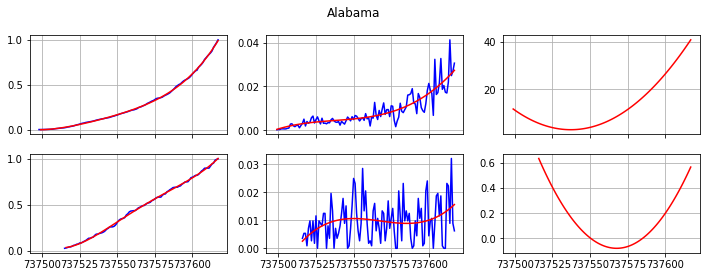

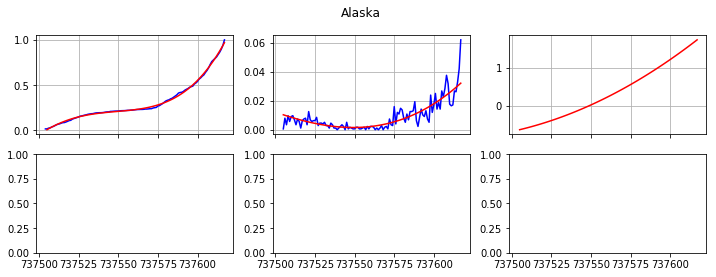

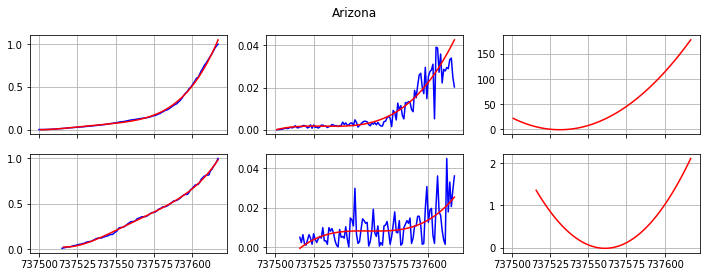

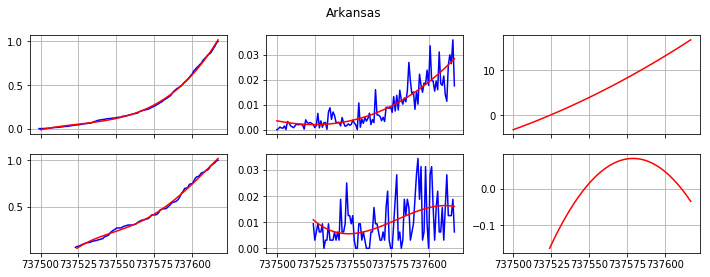

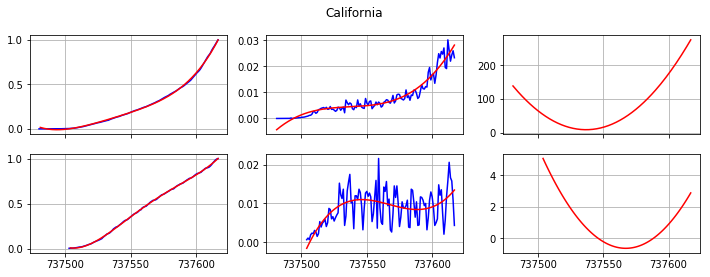

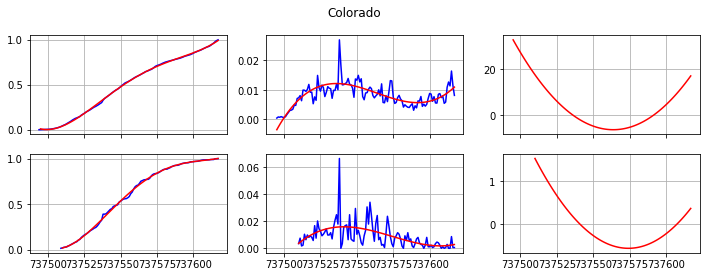

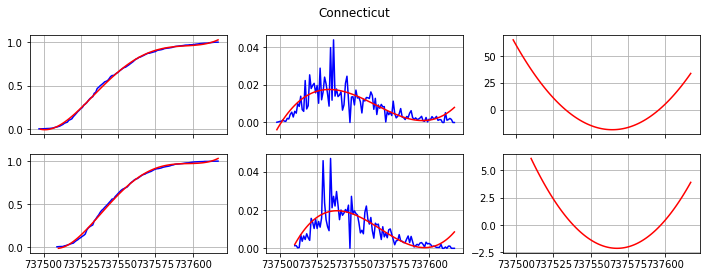

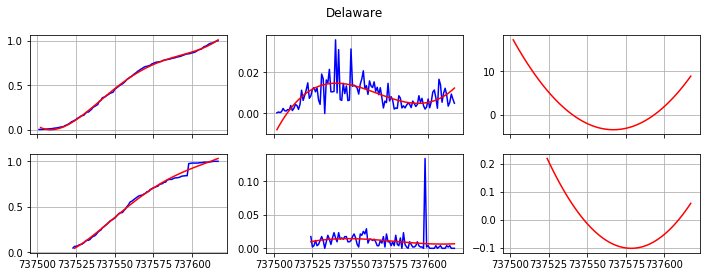

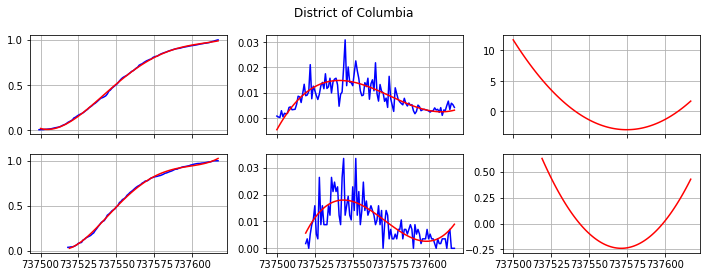

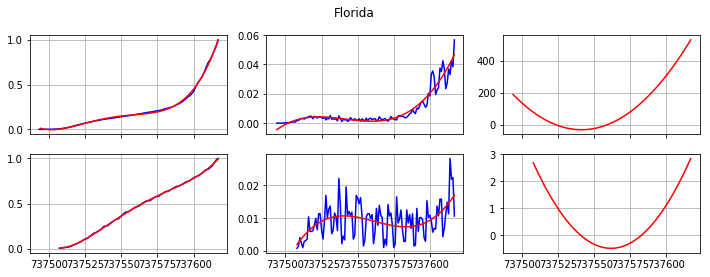

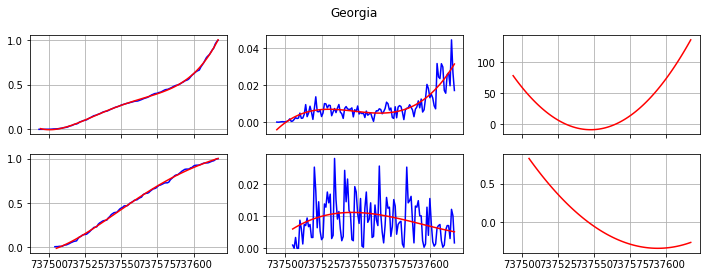

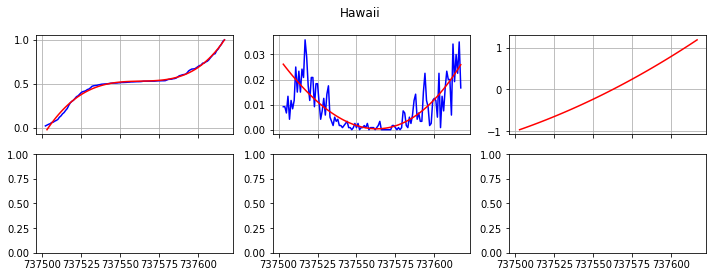

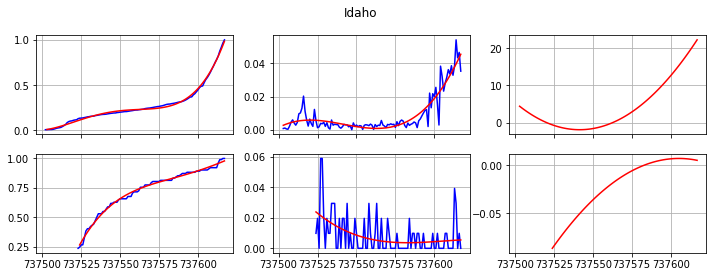

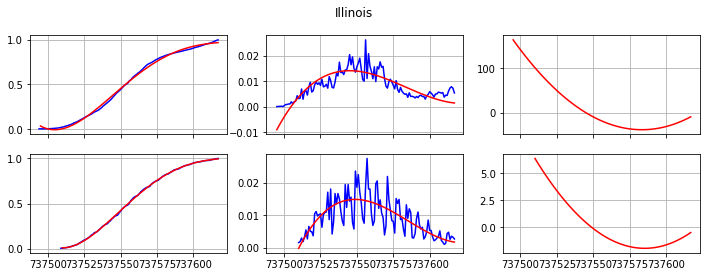

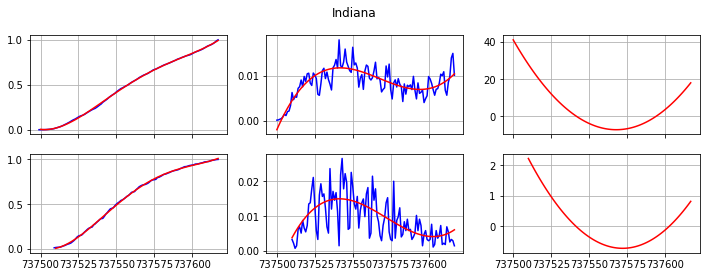

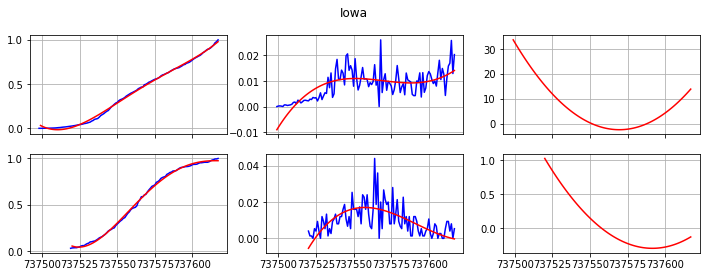

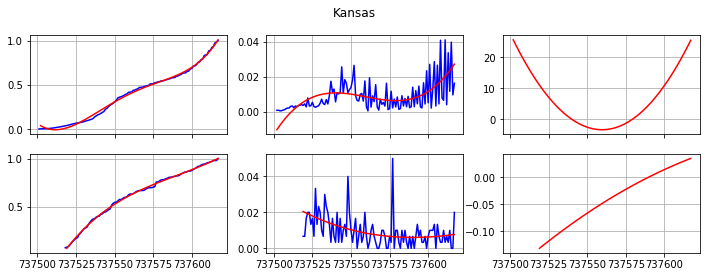

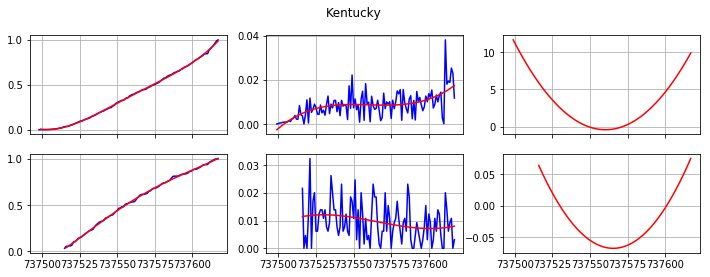

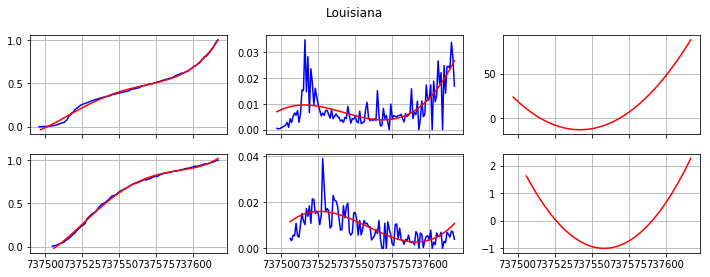

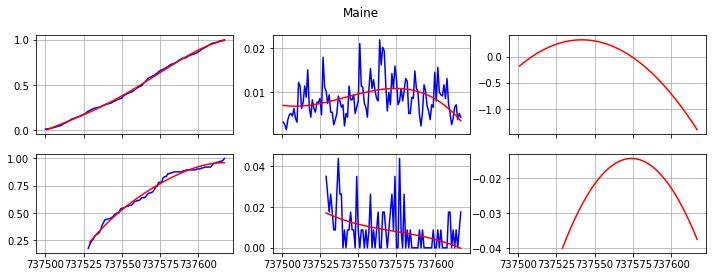

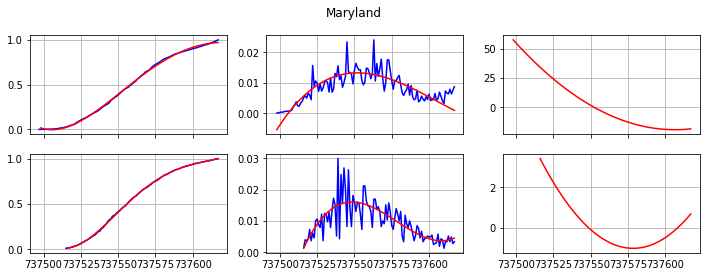

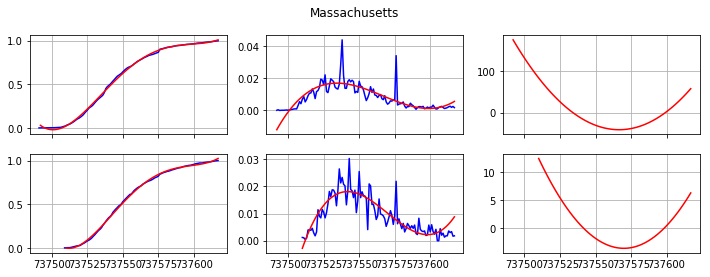

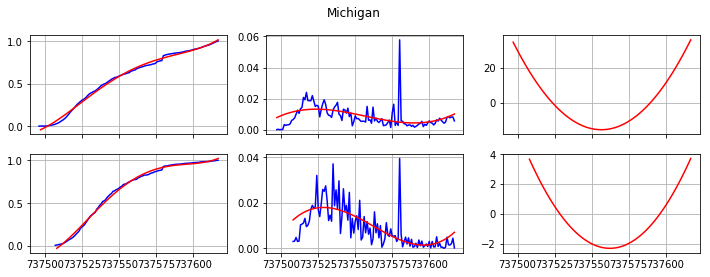

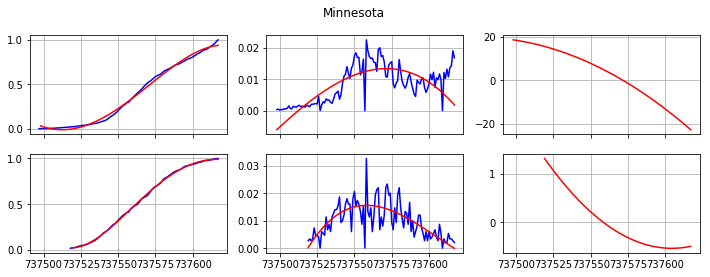

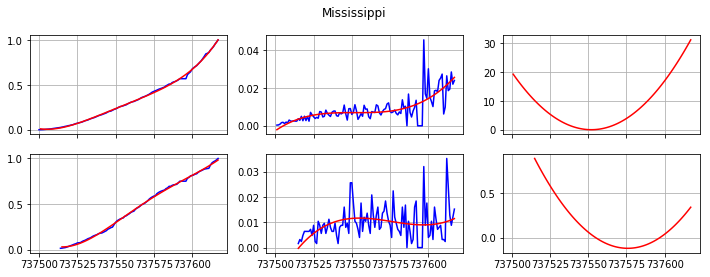

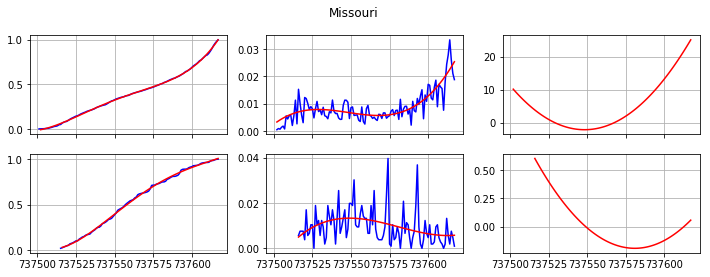

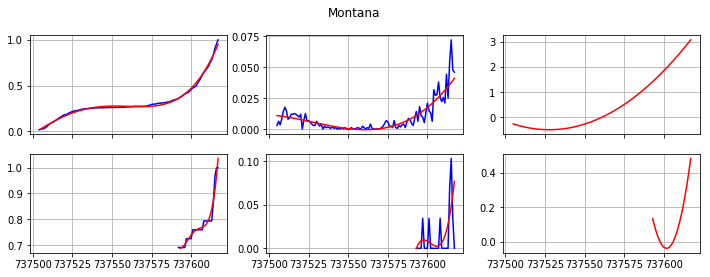

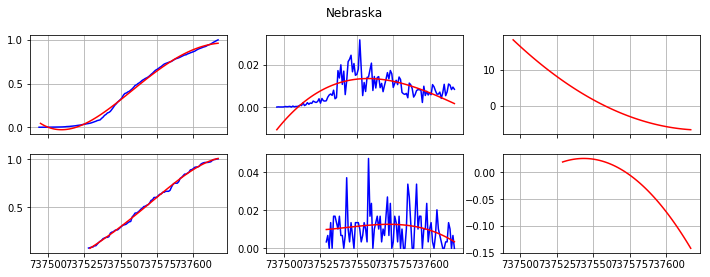

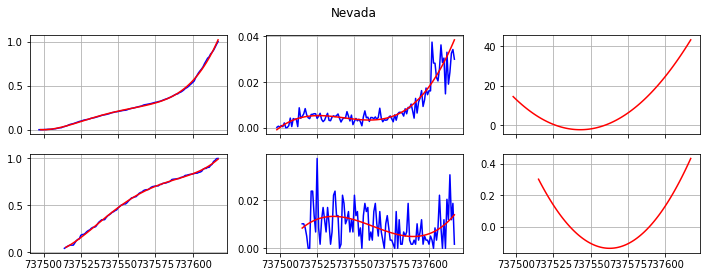

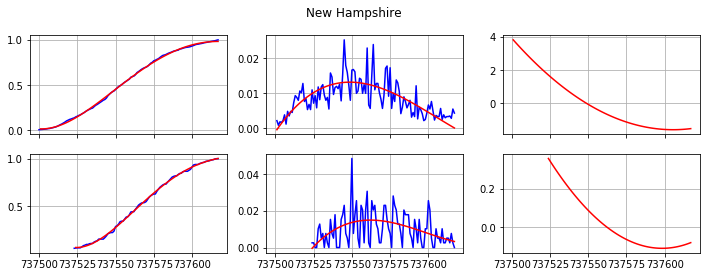

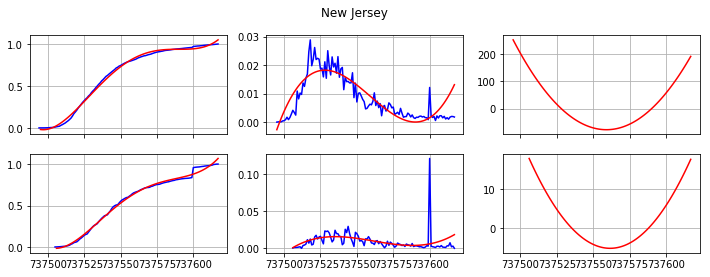

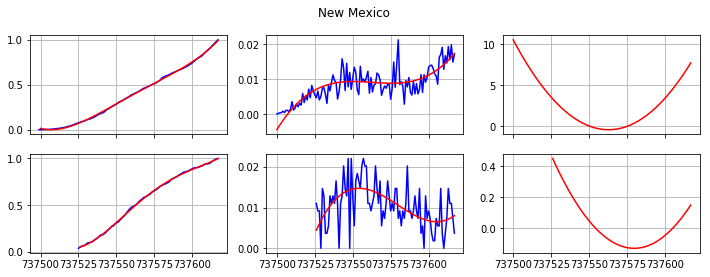

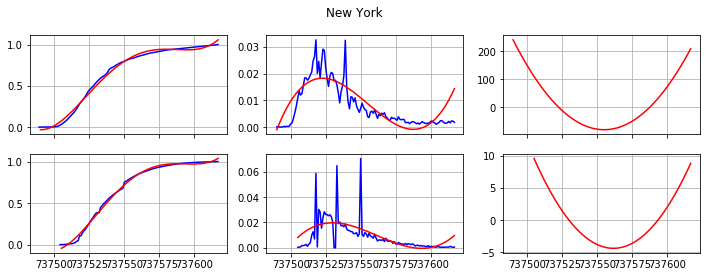

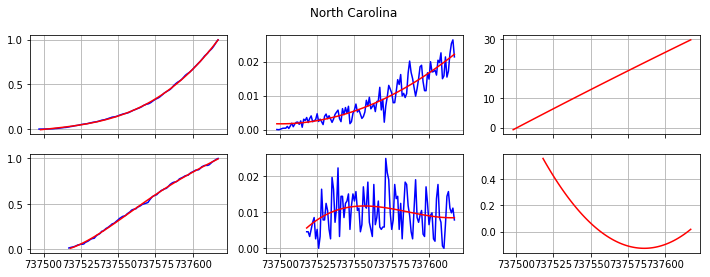

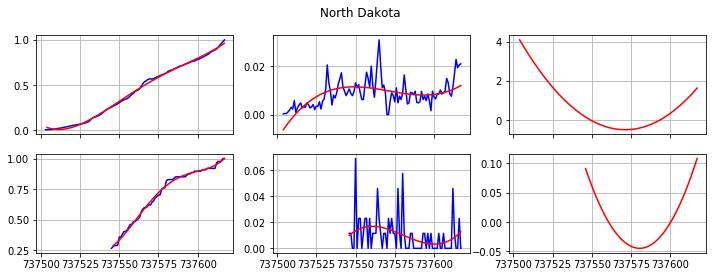

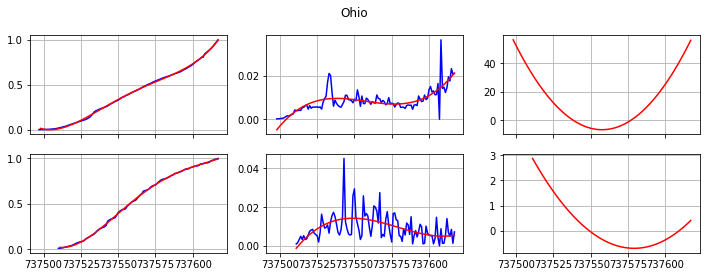

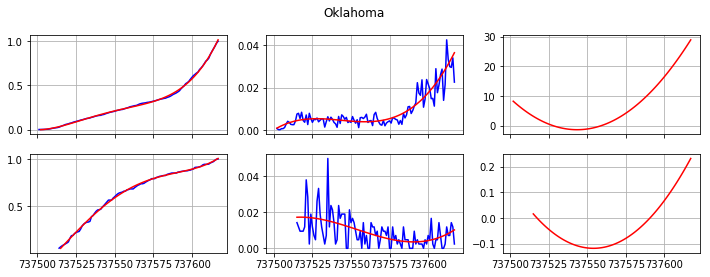

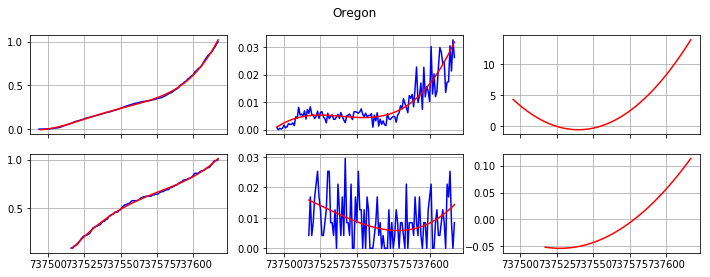

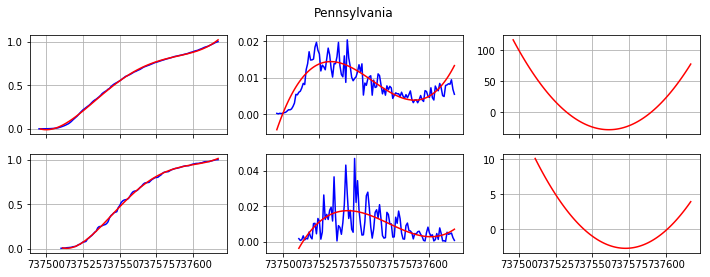

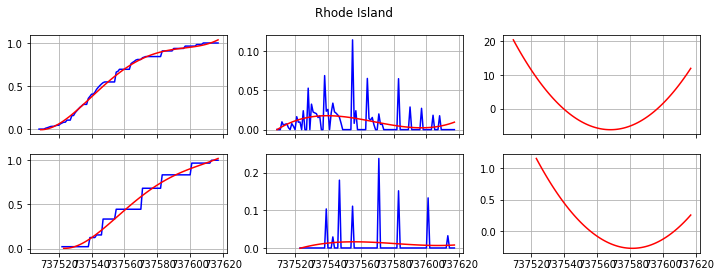

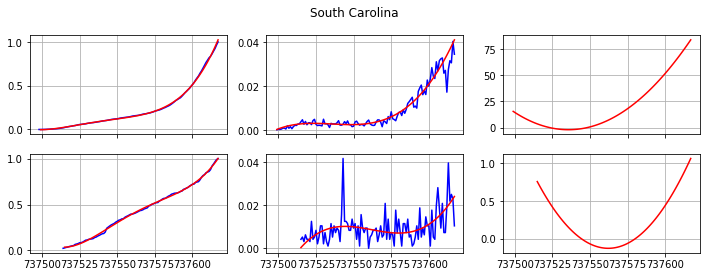

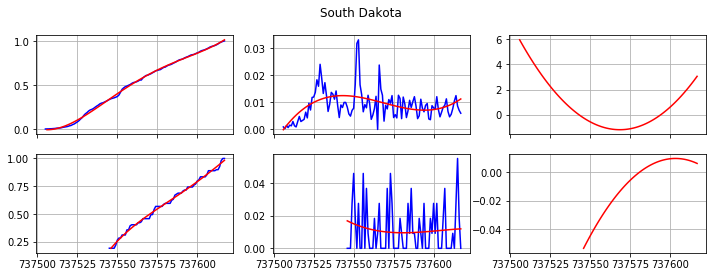

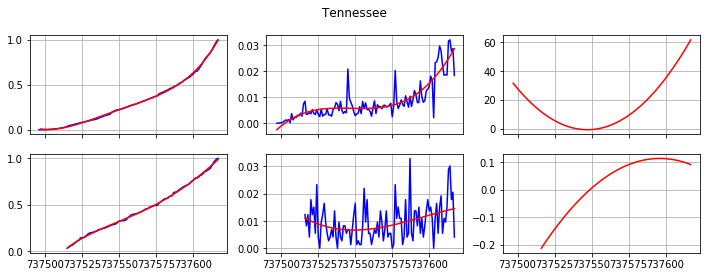

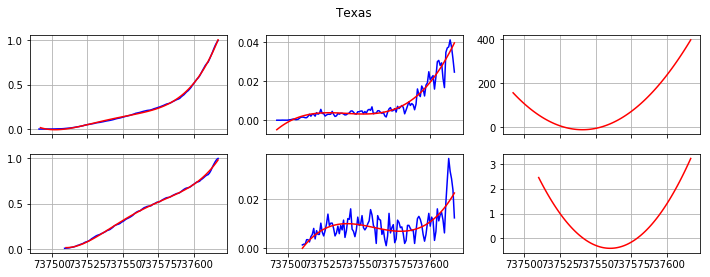

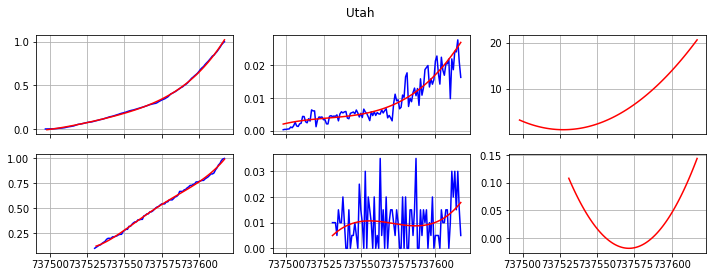

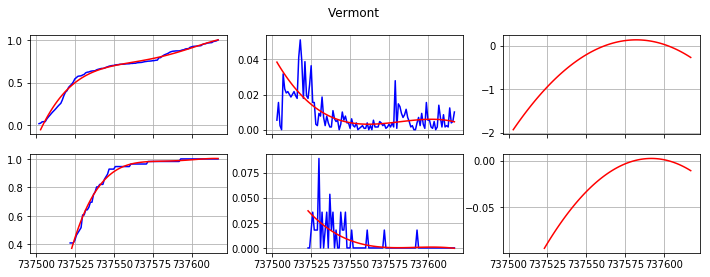

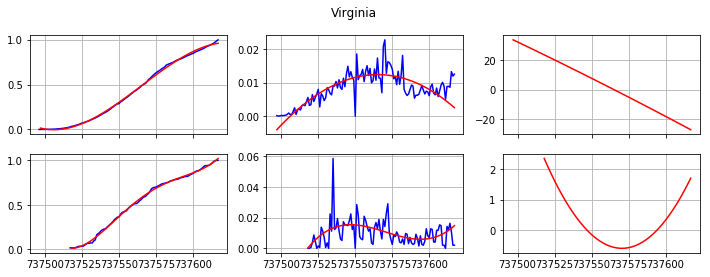

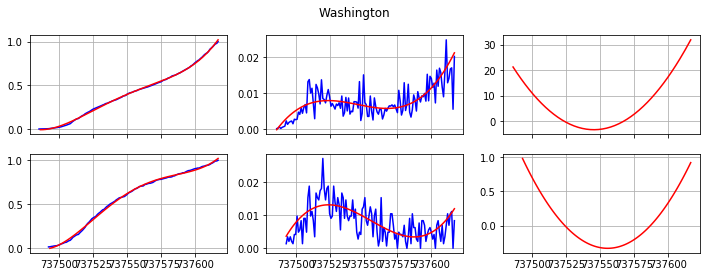

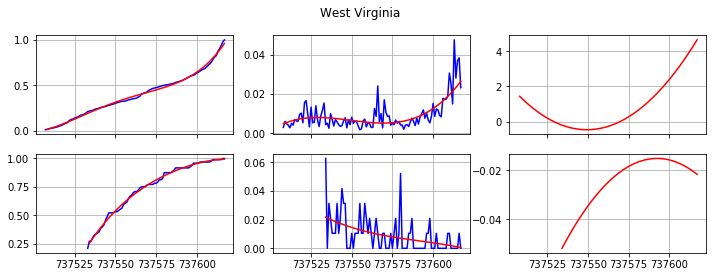

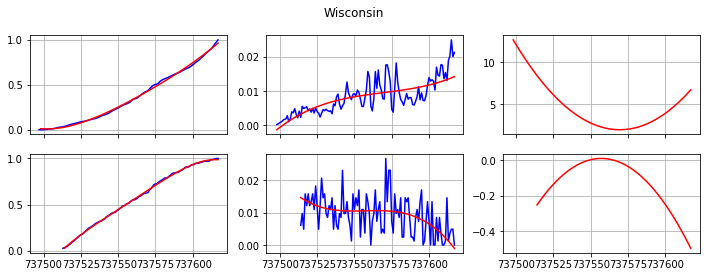

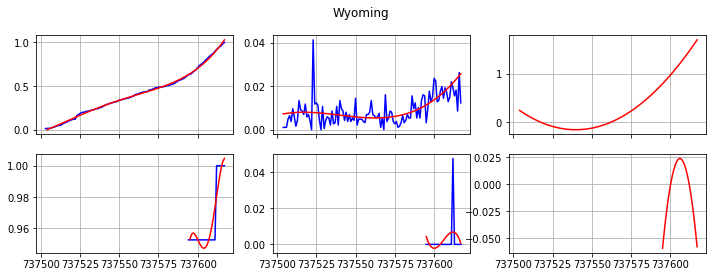

In [61]:
def plot_feature_graphs():
    def build_single_state_feature_graphs(state_id, pdf):
        current_state_cases_stats = state_stats_cases_dict[state_id]
        if state_id in state_stats_deaths_dict:
            current_state_deaths_stats = state_stats_deaths_dict[state_id]
    
        fig, ((ax11, ax21, ax31), (ax12, ax22, ax32)) = (
            plt.subplots(2, 3, figsize=(12, 4), sharex=True))
        fig.suptitle(current_state_cases_stats['state_name'])
    
        ax11.plot(current_state_cases_stats['base_vals'][:, 1], 
                  current_state_cases_stats['base_vals'][:, 2], 'b')
        ax11.plot(current_state_cases_stats['smoothed_vals'][:, 1], 
                  current_state_cases_stats['smoothed_vals'][:, 2], 'r')
        ax11.grid()
        
        ax21.plot(current_state_cases_stats['base_diffs'][:, 1], 
                  current_state_cases_stats['base_diffs'][:, 2], 'b')
        ax21.plot(current_state_cases_stats['smoothed_diffs'][:, 1], 
                  current_state_cases_stats['smoothed_diffs'][:, 2], 'r')
        ax21.grid()
    
        ax31.plot(current_state_cases_stats['smoothed_diff_derivs'][:, 1], 
                  current_state_cases_stats['smoothed_diff_derivs'][:, 2], 
                  'r')
        ax31.grid()

        if state_id in state_stats_deaths_dict:
            ax12.plot(current_state_deaths_stats['base_vals'][:, 1],           
                      current_state_deaths_stats['base_vals'][:, 2], 'b')
            ax12.plot(current_state_deaths_stats['smoothed_vals'][:, 1],
                      current_state_deaths_stats['smoothed_vals'][:, 2], 'r')
            ax12.grid()
            
            ax22.plot(current_state_deaths_stats['base_diffs'][:, 1], 
                      current_state_deaths_stats['base_diffs'][:, 2], 'b')
            ax22.plot(current_state_deaths_stats['smoothed_diffs'][:, 1], 
                      current_state_deaths_stats['smoothed_diffs'][:, 2], 'r')
            ax22.grid()
            
            ax32.plot(current_state_deaths_stats['smoothed_diff_derivs'][:, 1], 
                      current_state_deaths_stats['smoothed_diff_derivs'][:, 2], 
                      'r')
            ax32.grid()
            
        pdf.savefig(fig)
        plt.show()
        plt.close()

        return None
    
    state_stats_cases_dict = build_state_stats_dict('cases')
    state_stats_deaths_dict = build_state_stats_dict('deaths')

    with PdfPages('state_stats_graph.pdf') as pdf:
        for state_id in state_stats_cases_dict:
            build_single_state_feature_graphs(state_id, pdf)

    return None

ddddplot_feature_graphs()

In [83]:

def build_GAM_state_stats_dict(target_feature_name):
    state_stats_dict = {}
    for state_name in np.unique(state_data.index.get_level_values(0)):
        restricted_state_data = state_data[state_data.index.get_level_values(0) == state_name]
        state_cases = restricted_state_data[restricted_state_data[[target_feature_name]].values >= 20]
        
        if state_cases.shape[0] < 10:
            continue
    
        x = state_cases.index.get_level_values(1).values.reshape(-1)
        y_base = state_cases[[target_feature_name]].cummax().values.reshape(-1)
        ##y_base_max = np.max(y_base)
        y = (y_base[1:] - y_base[:-1])
        ##y_max = np.max(y)
        ##y = y / y_base_max
        
        x = x[y_base > 0]
        y = y[(y_base > 0)[1:]]
        y_base = y_base[y_base > 0]
        
        spl_base = pygam.pygam.GAM(
            terms=pygam.terms.s(0, constraints='monotonic_inc'),
            distribution=pygam.distributions.NormalDist(2.0),
            n_splines=20,
            spline_order=5)
        spl_base.fit(
            state_cases.index.get_level_values(1).values.reshape(-1), 
            y_base)
        
        ## We use a bit of cleverness here. 
        ## Sinceanyy spline is completely determined by the location of 
        ## its knots and its values at those knots, we use the 
        ## standard interpolating spline through those values.
        x_spl = np.linspace(np.min(x), np.max(x), 40)
        y_spl = spl_base.predict(x_spl)
        
        x_knots = np.linspace(np.min(x), np.max(x), 20)
        
        spl = LSQUnivariateSpline(
            x=x_spl,
            y=y_spl,
            t=x_knots[1:-1],
            k=5)
        
        xs = np.arange(np.min(x) + 1, np.max(x) + 1)
        ys_base = spl(xs)
                            
        ys = spl.derivative(1)(xs)
        dydxs = spl.derivative(2)(xs)
        
        state_id = state_cases[['state_id']].values.reshape(-1)[0]
        base_fips = np.empty(y_base.shape[0])
        base_fips[:] = state_id
        base_diff_fips = np.empty([x.shape[0]])
        base_diff_fips[:] = state_id
        smoothed_fips = np.empty([xs.shape[0]])
        smoothed_fips[:] = state_id
                
        state_stats_dict[int(state_id)] = (            
            {
                'state_name' : state_name,
                'base_vals' : np.vstack((base_fips, 
                                         state_cases.index.get_level_values(1).values.reshape(-1), 
                                         y_base)).T,
                'smoothed_vals' : np.vstack((smoothed_fips, xs, ys_base)).T,
                'base_diffs' : np.vstack((base_diff_fips[1:], x[1:], y)).T, 
                'smoothed_diffs' : np.vstack((smoothed_fips, xs, ys)).T, 
                'smoothed_diff_derivs': np.vstack((smoothed_fips, xs, dydxs)).T,
            })
            
    return state_stats_dict

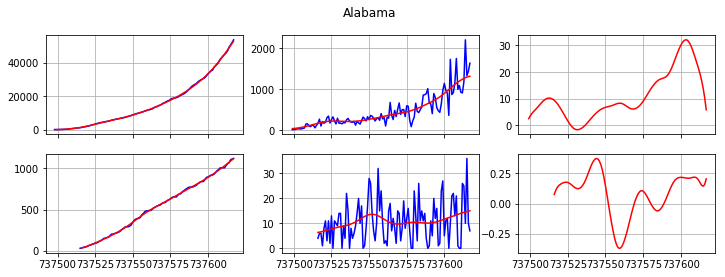

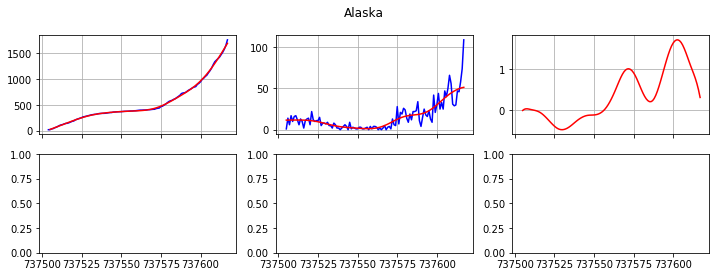

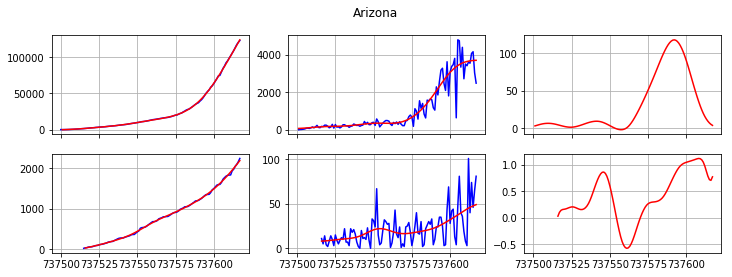

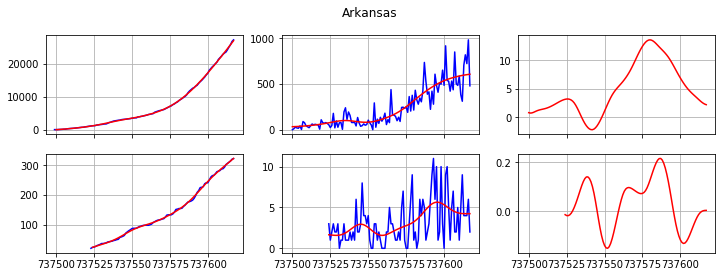

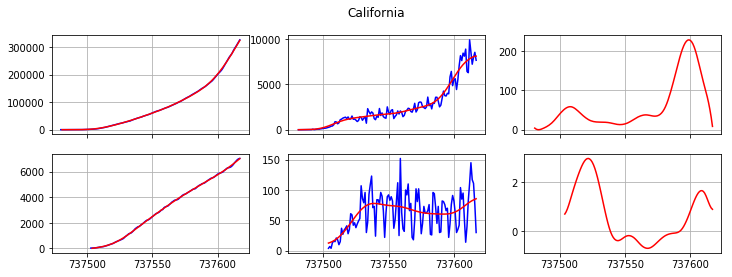

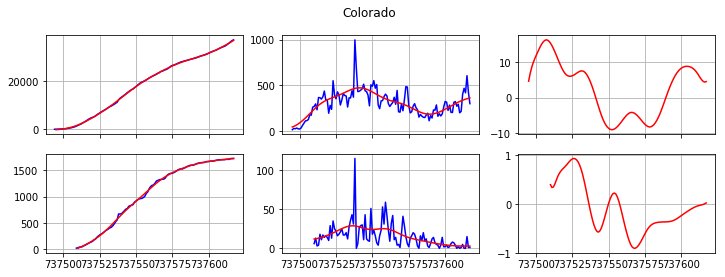

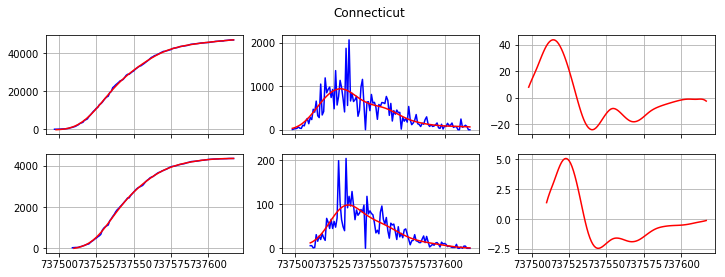

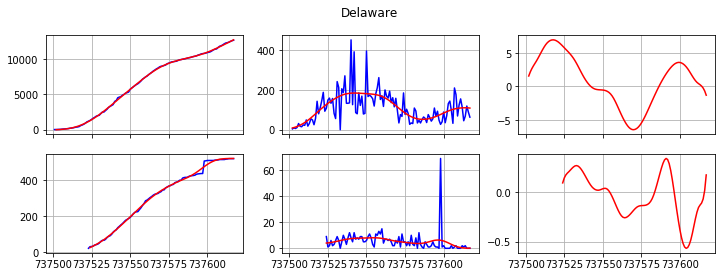

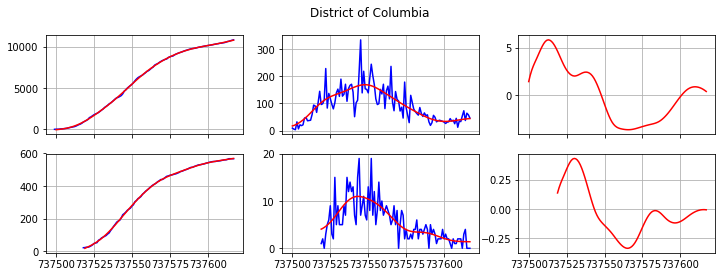

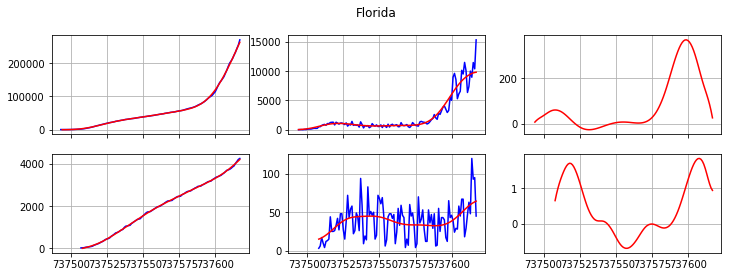

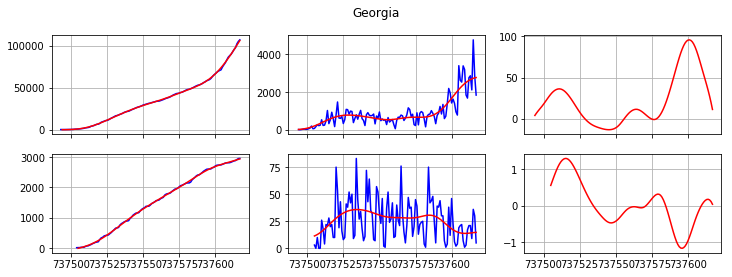

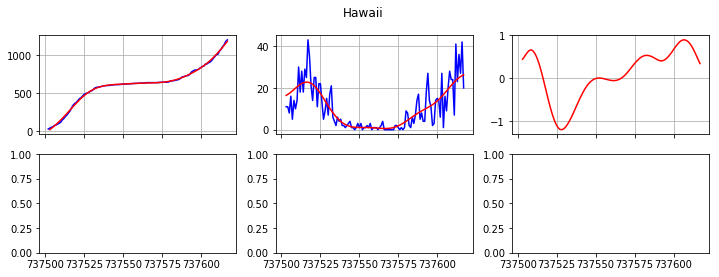

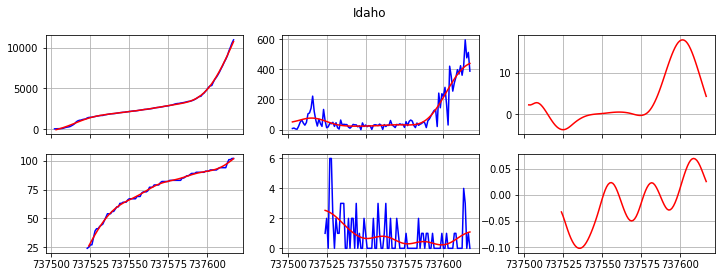

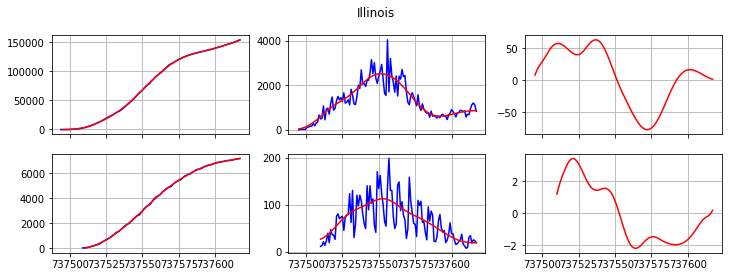

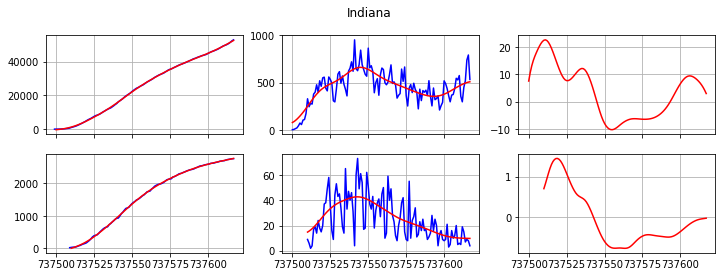

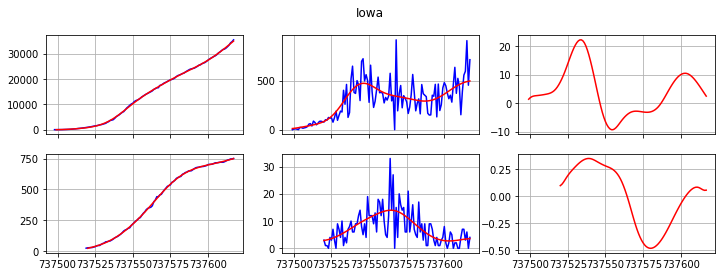

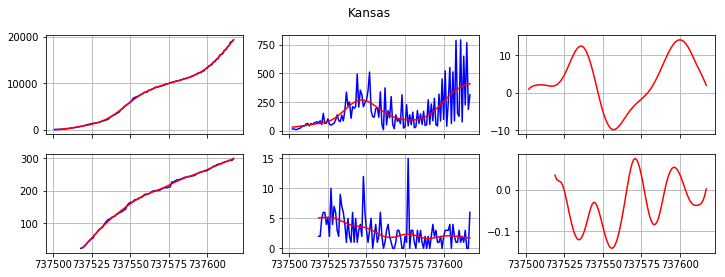

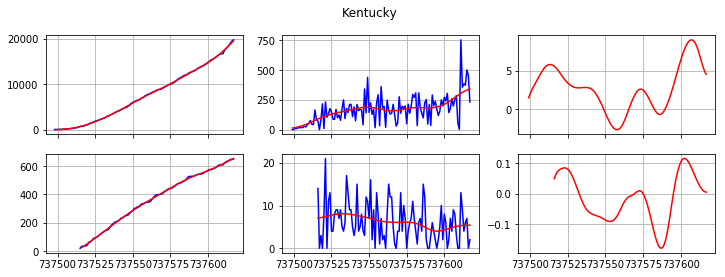

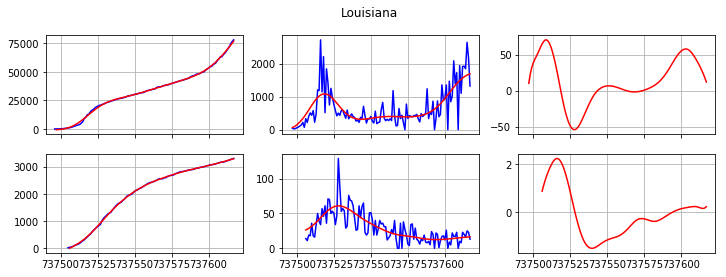

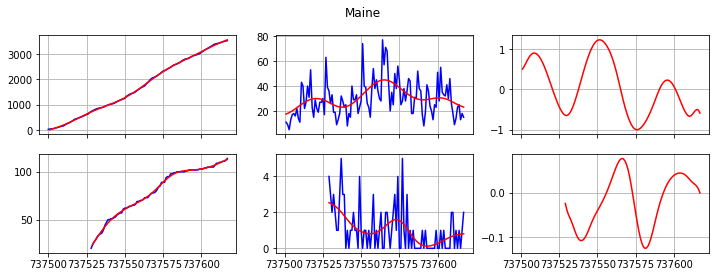

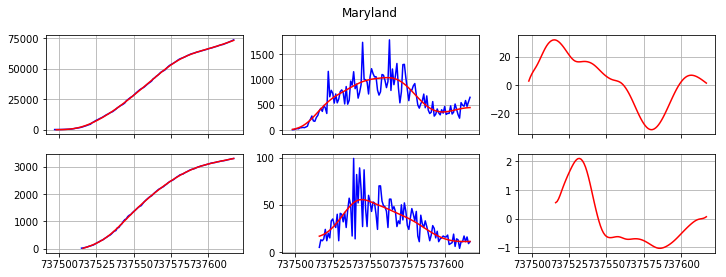

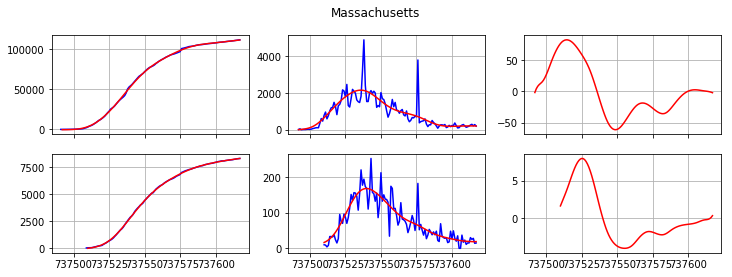

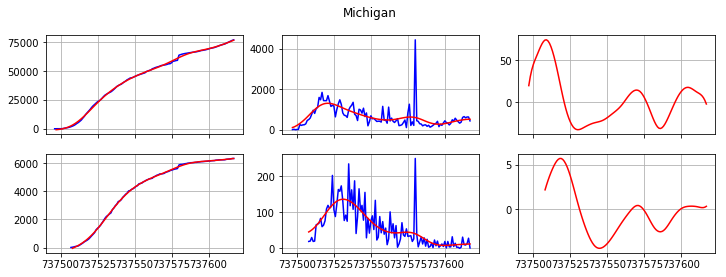

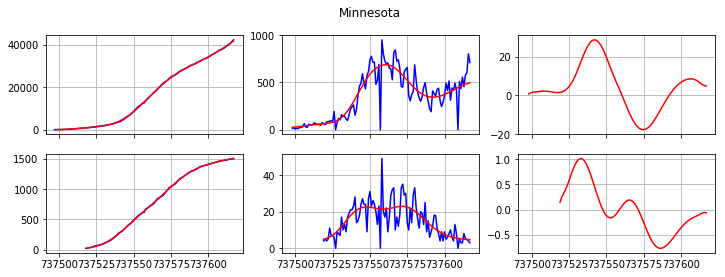

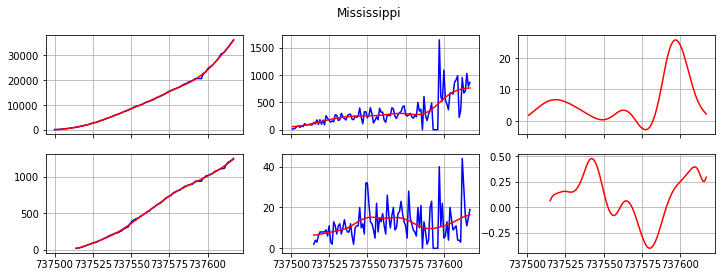

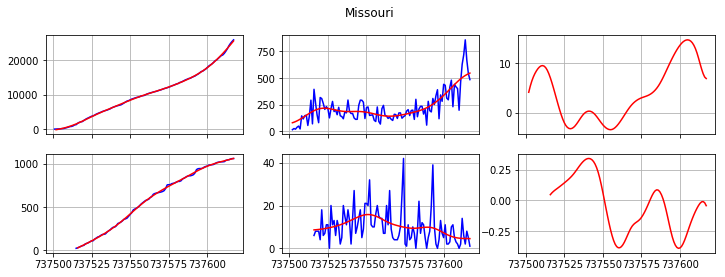

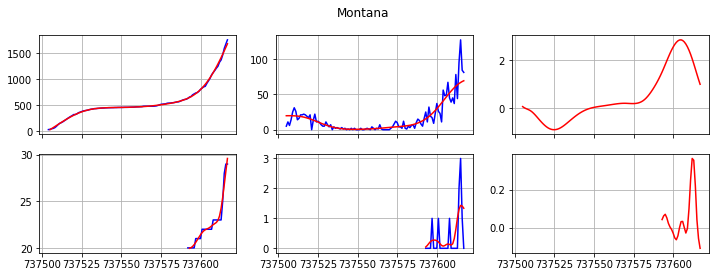

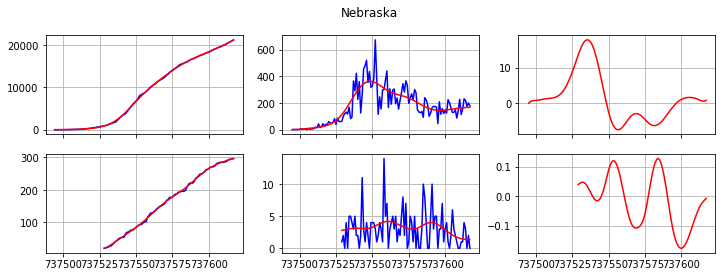

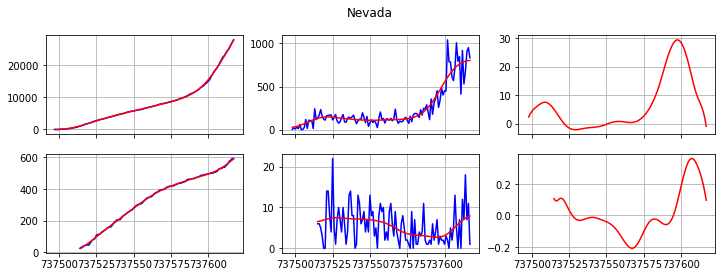

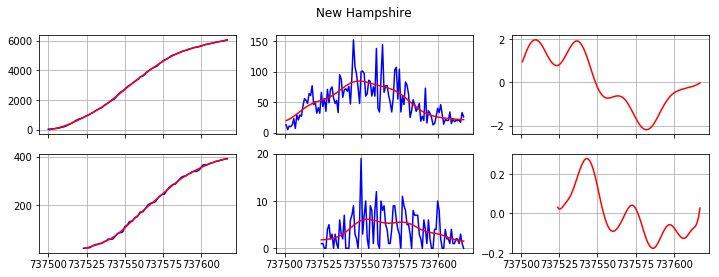

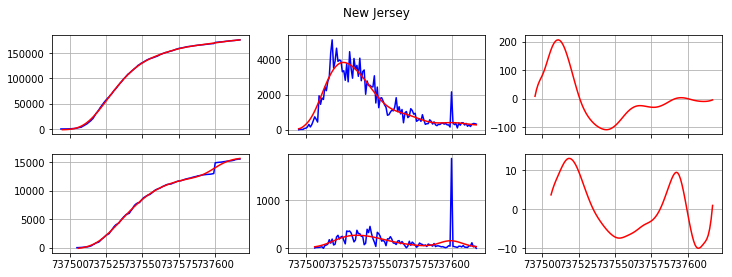

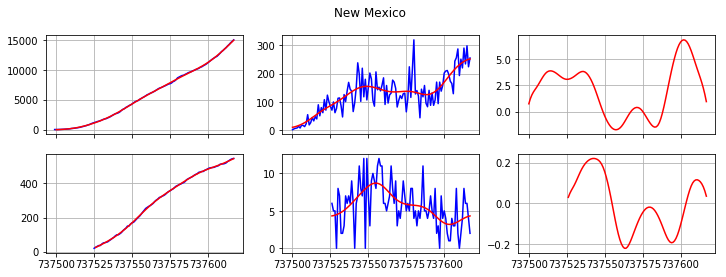

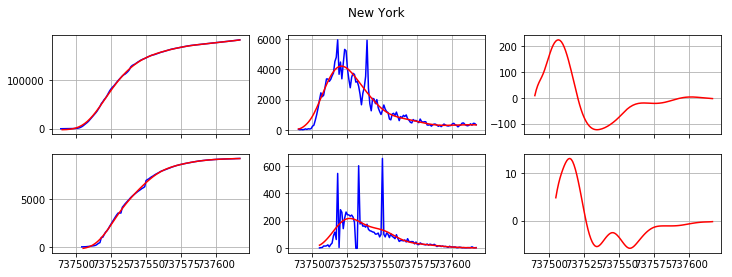

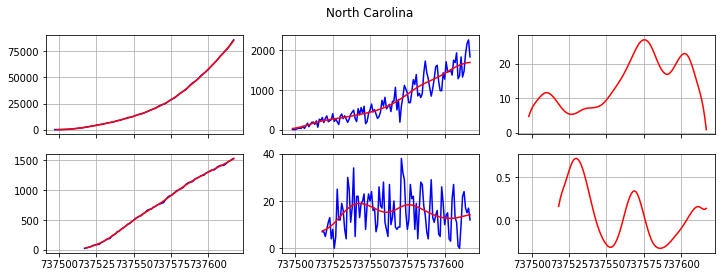

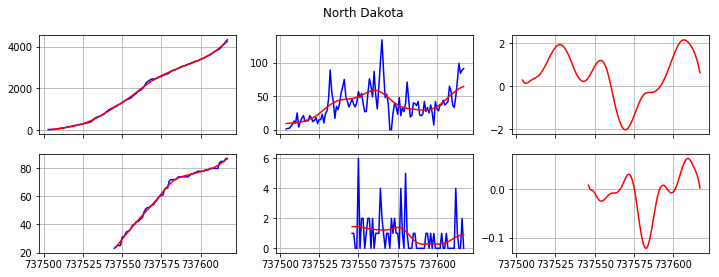

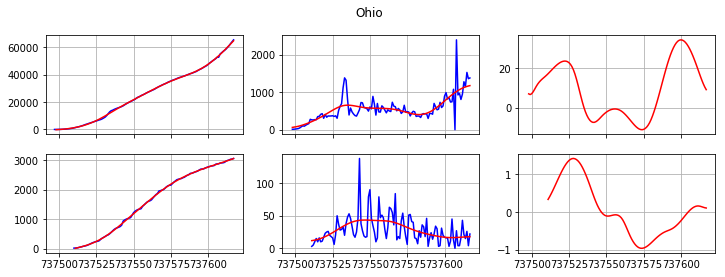

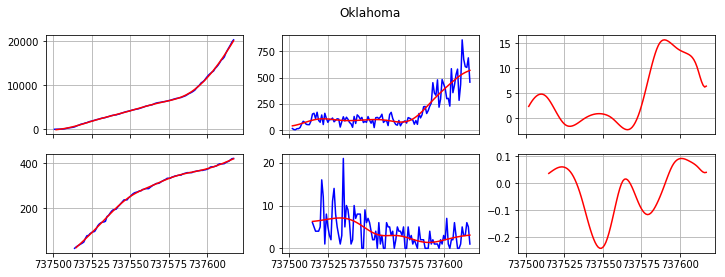

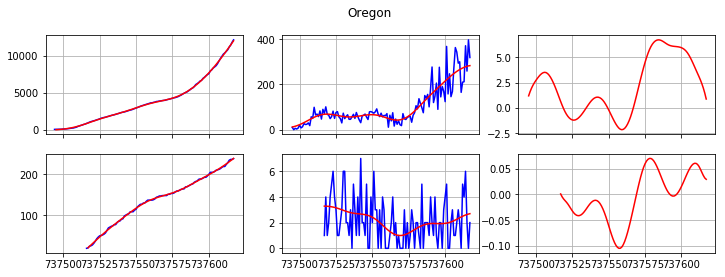

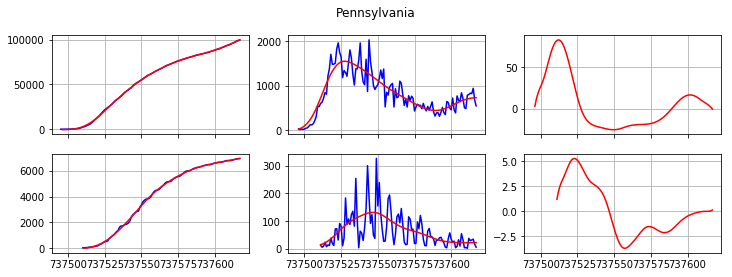

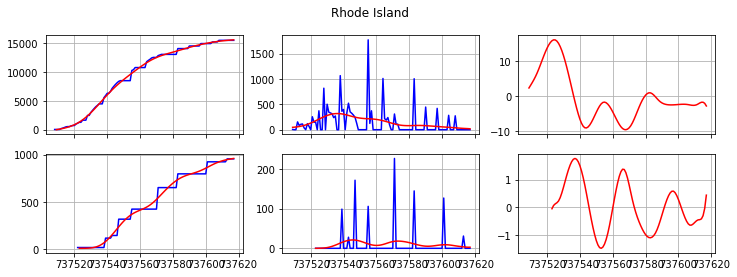

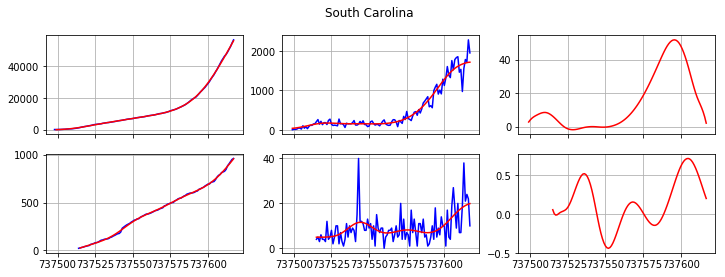

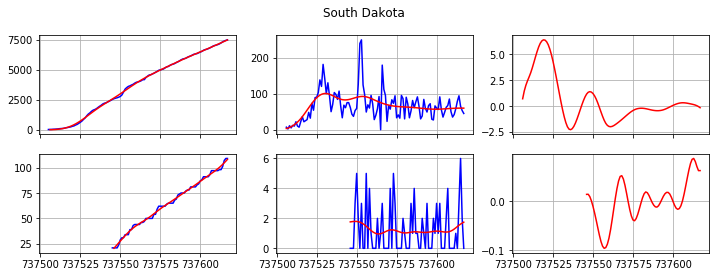

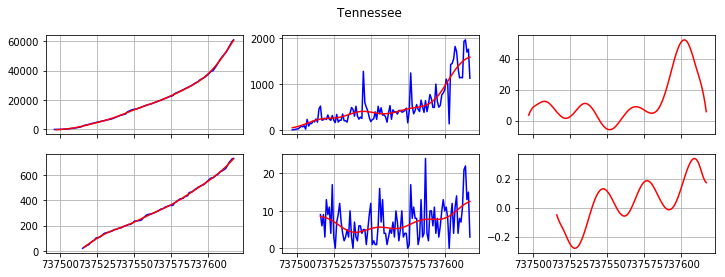

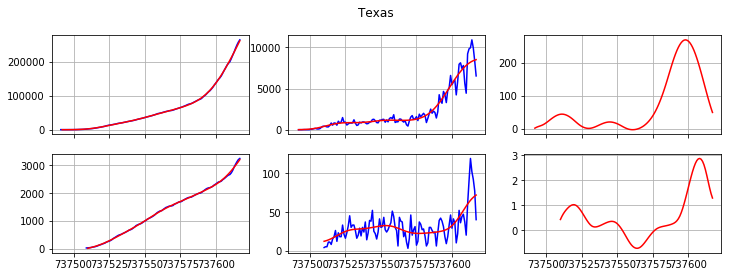

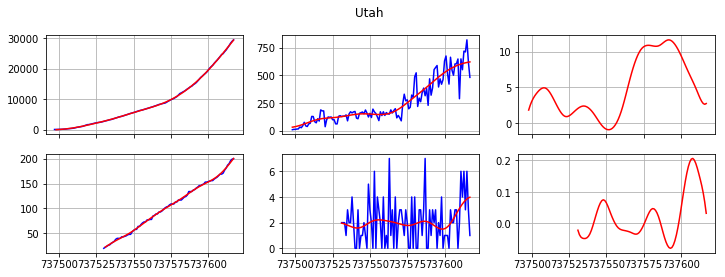

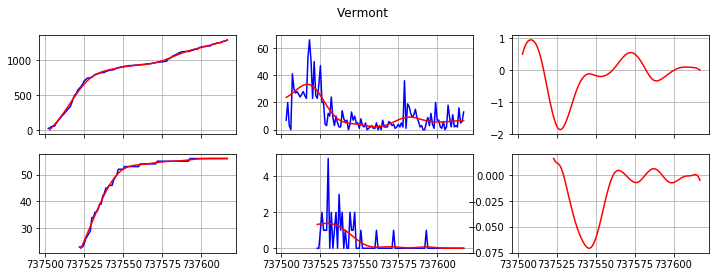

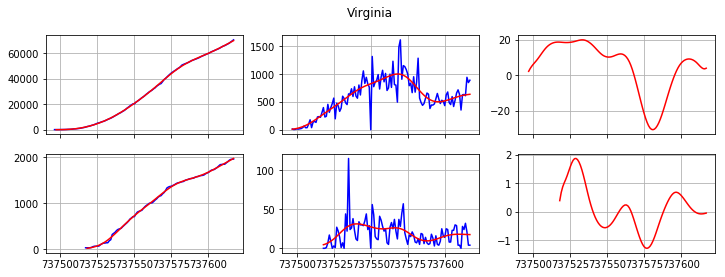

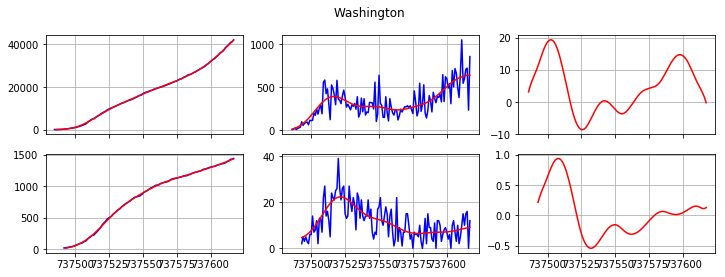

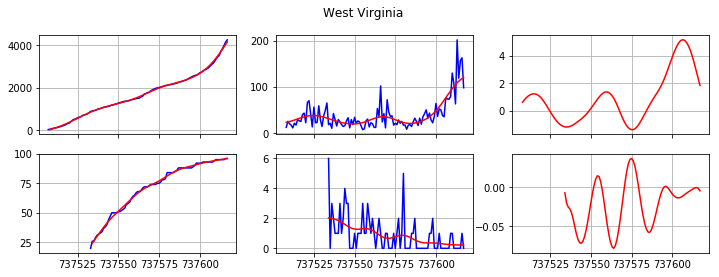

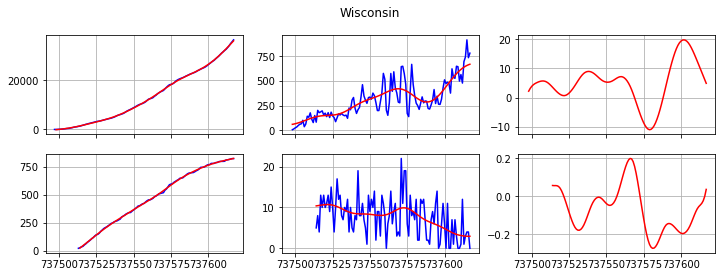

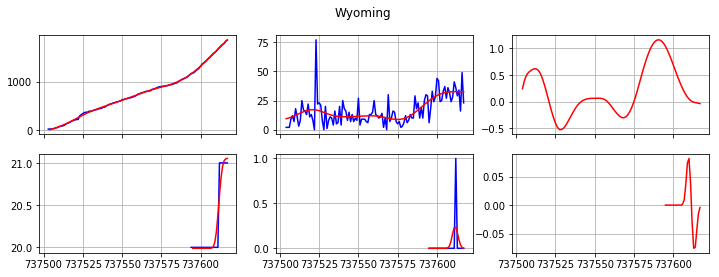

In [84]:
def plot_feature_graphs():
    def build_single_state_feature_graphs(state_id, pdf):
        current_state_cases_stats = state_stats_cases_dict[state_id]
        if state_id in state_stats_deaths_dict:
            current_state_deaths_stats = state_stats_deaths_dict[state_id]
    
        fig, ((ax11, ax21, ax31), (ax12, ax22, ax32)) = (
            plt.subplots(2, 3, figsize=(12, 4), sharex=True))
        fig.suptitle(current_state_cases_stats['state_name'])
    
        ax11.plot(current_state_cases_stats['base_vals'][:, 1], 
                  current_state_cases_stats['base_vals'][:, 2], 'b')
        ax11.plot(current_state_cases_stats['smoothed_vals'][:, 1], 
                  current_state_cases_stats['smoothed_vals'][:, 2], 'r')
        ax11.grid()
        
        ax21.plot(current_state_cases_stats['base_diffs'][:, 1], 
                  current_state_cases_stats['base_diffs'][:, 2], 'b')
        ax21.plot(current_state_cases_stats['smoothed_diffs'][:, 1], 
                  current_state_cases_stats['smoothed_diffs'][:, 2], 'r')
        ax21.grid()
    
        ax31.plot(current_state_cases_stats['smoothed_diff_derivs'][:, 1], 
                  current_state_cases_stats['smoothed_diff_derivs'][:, 2], 
                  'r')
        ax31.grid()

        if state_id in state_stats_deaths_dict:
            ax12.plot(current_state_deaths_stats['base_vals'][:, 1],           
                      current_state_deaths_stats['base_vals'][:, 2], 'b')
            ax12.plot(current_state_deaths_stats['smoothed_vals'][:, 1],
                      current_state_deaths_stats['smoothed_vals'][:, 2], 'r')
            ax12.grid()
            
            ax22.plot(current_state_deaths_stats['base_diffs'][:, 1], 
                      current_state_deaths_stats['base_diffs'][:, 2], 'b')
            ax22.plot(current_state_deaths_stats['smoothed_diffs'][:, 1], 
                      current_state_deaths_stats['smoothed_diffs'][:, 2], 'r')
            ax22.grid()
            
            ax32.plot(current_state_deaths_stats['smoothed_diff_derivs'][:, 1], 
                      current_state_deaths_stats['smoothed_diff_derivs'][:, 2], 
                      'r')
            ax32.grid()
            
        pdf.savefig(fig)
        plt.show()
        plt.close()

        return None
    
    state_stats_cases_dict = build_GAM_state_stats_dict('cases')
    state_stats_deaths_dict = build_GAM_state_stats_dict('deaths')

    with PdfPages('dummy_state_stats_graph.pdf') as pdf:
        for state_id in state_stats_cases_dict:
            build_single_state_feature_graphs(state_id, pdf)

    return None

plot_feature_graphs()